<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/prophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import the Necessary Library**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error


# **2. Load the Dataset**

---



In [2]:
df=pd.read_csv('/content/cleaned_uv_data.csv')
df.head()

,instance_date,uv_index_daily_max
0,1999-12-31,0.304709
1,2000-01-01,0.316398
2,2000-01-02,0.329537
3,2000-01-03,0.388613
4,2000-01-04,0.384048


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   instance_date       1786 non-null   object 
 1   uv_index_daily_max  1786 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.0+ KB


# **3. Preprocess the Data**


In [4]:

# Ensure the date column is in datetime format
df['instance_date'] = pd.to_datetime(df['instance_date'])

# Rename columns to match Prophet's expected format
df = df.rename(columns={'instance_date': 'ds', 'uv_index_daily_max': 'y'})


In [5]:
# Define cutoff date for the last 6 months
cutoff_date = df["ds"].max() - pd.DateOffset(months=2)

# Split data
train_data = df[df["ds"] <= cutoff_date]
test_data = df[df["ds"] > cutoff_date]

# Display the split
train_data.tail(), test_data.head()

(             ds         y
 1720 2004-10-26  0.064930
 1721 2004-10-27  0.312255
 1722 2004-10-28  0.171484
 1723 2004-10-29  0.080123
 1724 2004-10-30  0.477644,
              ds         y
 1725 2004-10-31  0.394703
 1726 2004-11-01  0.117053
 1727 2004-11-02  0.136129
 1728 2004-11-03  0.405228
 1729 2004-11-04  0.432499)

In [6]:
df

,ds,y
0,1999-12-31,0.304709
1,2000-01-01,0.316398
2,2000-01-02,0.329537
3,2000-01-03,0.388613
4,2000-01-04,0.384048
...,...,...
1781,2004-12-26,0.075711
1782,2004-12-27,0.246608
1783,2004-12-28,0.141356
1784,2004-12-29,0.189241


# **4. Training the Prophet Model**

In [7]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# Fit the model on the training data
model.fit(train_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ie75h85/1d_r1ri3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ie75h85/83p1j6qo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99819', 'data', 'file=/tmp/tmp3ie75h85/1d_r1ri3.json', 'init=/tmp/tmp3ie75h85/83p1j6qo.json', 'output', 'file=/tmp/tmp3ie75h85/prophet_modelg2cnaa_s/prophet_model-20250327183331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
#Making Predictions
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)


In [9]:
# adding Forecast to df
df['Forecast'] = forecast['yhat']
df['Lower Bound'] = forecast['yhat_lower']
df['Upper Bound'] = forecast['yhat_upper']


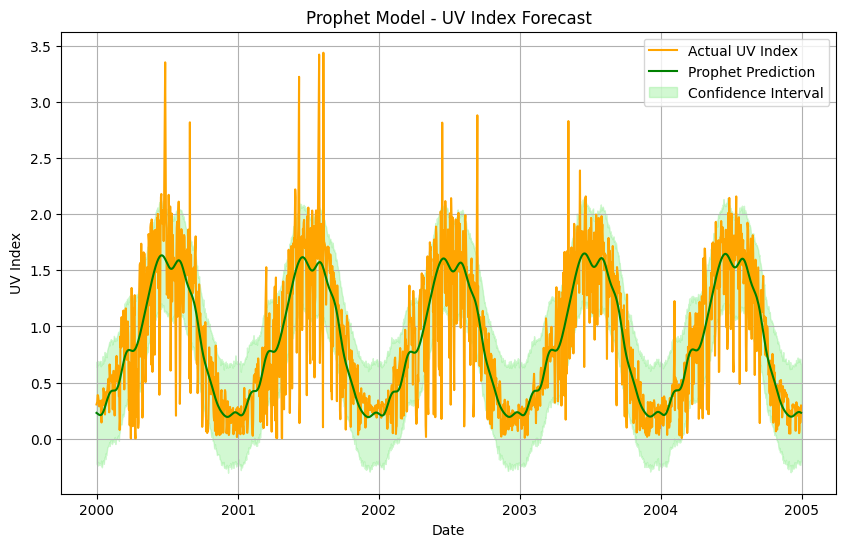

In [10]:
#Plot Predictions vs Actuals
plt.figure(figsize=(10, 6))

plt.plot(df['ds'], df['y'], label='Actual UV Index', color='orange')
if 'yhat' in forecast.columns and 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns:
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Prediction', color='green')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='lightgreen',
        alpha=0.4,
        label='Confidence Interval'
    )
else:
    print("Forecast data is missing necessary columns!")

plt.legend()
plt.title('Prophet Model - UV Index Forecast')
plt.xlabel('Date')
plt.ylabel('UV Index')
plt.grid(True)

plt.show()



# **5. Model Evaluation**

In [11]:
y_test = test_data['y'].values
y_pred = forecast['yhat'].iloc[-len(test_data):].values

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 0.10
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.12
